In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import os

# Define a simple CNN model (this can be replaced with a more complex model like ResNet, VGG, etc.)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model
def train_model(model, train_loader, epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

    print('Finished Training')
    return model

# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize models
model_A = SimpleCNN()
model_B = SimpleCNN()

# Check if pre-trained models exist
if not os.path.exists('model_A.pth'):
    print("Training Model A...")
    model_A = train_model(model_A, train_loader)
    torch.save(model_A.state_dict(), 'model_A.pth')  # Save the model

if not os.path.exists('model_B.pth'):
    print("Training Model B...")
    model_B = train_model(model_B, train_loader)
    torch.save(model_B.state_dict(), 'model_B.pth')  # Save the model

# Load pre-trained models if they exist
if os.path.exists('model_A.pth'):
    print("Loading Model A...")
    model_A.load_state_dict(torch.load('model_A.pth'))

if os.path.exists('model_B.pth'):
    print("Loading Model B...")
    model_B.load_state_dict(torch.load('model_B.pth'))

# Set models to evaluation mode
model_A.eval()
model_B.eval()

# Evaluation function
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Test the models after loading or training
accuracy_A = evaluate_model(model_A, test_loader)
accuracy_B = evaluate_model(model_B, test_loader)

print(f'Model A Accuracy: {accuracy_A:.2f}%')
print(f'Model B Accuracy: {accuracy_B:.2f}%')

# You can further extend the code here to perform the model merging techniques


Files already downloaded and verified
Files already downloaded and verified
Loading Model A...
Loading Model B...


<ipython-input-49-9665dbaccf30>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_A.load_state_dict(torch.load('model_A.pth'))
<ipython-input-49-9665dbaccf30>:80: Futu

Model A Accuracy: 73.69%
Model B Accuracy: 72.37%


In [ ]:
import numpy as np

# Base Models Average
def base_models_avg(models, test_loader):
    accuracies = []
    for model in models:
        acc = evaluate_model(model, test_loader)
        accuracies.append(acc)
    avg_accuracy = np.mean(accuracies)
    print(f"Base Models Avg Accuracy: {avg_accuracy:.2f}%")
    return avg_accuracy

# Evaluate Base Models Avg
models = [model_A, model_B]  # You can add more models if available
base_avg_accuracy = base_models_avg(models, test_loader)


Base Models Avg Accuracy: 73.03%


In [ ]:
def ensemble_models(models, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = [model(images) for model in models]
            ensemble_output = torch.mean(torch.stack(outputs), dim=0)  # Averaging logits
            _, predicted = torch.max(ensemble_output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Ensemble Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate Ensemble Accuracy
ensemble_accuracy = ensemble_models(models, test_loader)


Ensemble Accuracy: 75.82%


In [ ]:
def direct_averaging(models):
    # Ensure the same architecture for all models
    merged_model = models[0]  # Use model A's architecture as base
    with torch.no_grad():
        for param_A, *param_others in zip(models[0].parameters(), *[m.parameters() for m in models[1:]]):
            # Average all model parameters
            averaged_weights = torch.mean(torch.stack([param_A] + param_others), dim=0)
            param_A.data.copy_(averaged_weights)
    return merged_model

# Merge and evaluate Direct Averaging
direct_avg_model = direct_averaging([model_A, model_B])
direct_avg_accuracy = evaluate_model(direct_avg_model, test_loader)
print(f"Direct Averaging Accuracy: {direct_avg_accuracy:.2f}%")


Direct Averaging Accuracy: 36.11%


In [ ]:
import torch

# Function to generate a permutation matrix
def get_permutation_matrix(param_A, param_B):
    # Ensure only layers with the same number of neurons are permuted
    if param_A.size(0) == param_B.size(0):
        return torch.randperm(param_A.size(0))
    else:
        return None  # Skip if the layers are not compatible

# Function to apply the permutation
def apply_permutation(param_B, permutation):
    # Apply permutation based on layer type (fully connected or convolutional)
    if permutation is not None:
        if param_B.dim() == 2:  # Fully connected layer
            return param_B[permutation, :]  # Permuting rows (neurons)
        elif param_B.dim() == 1:  # Bias layer
            return param_B[permutation]
        elif param_B.dim() == 4:  # Convolutional layer
            return param_B[permutation, :, :, :]  # Permute filters (output channels)
    return param_B  # If no permutation, return param_B unchanged

# Main function to permute neurons
def permute_neurons(model_A, model_B):
    with torch.no_grad():
        for param_A, param_B in zip(model_A.parameters(), model_B.parameters()):
            if param_A.shape == param_B.shape:  # Ensure layers have the same shape
                # Get the permutation matrix for matching neurons
                permutation_matrix = get_permutation_matrix(param_A, param_B)
                if permutation_matrix is not None:
                    permuted_param_B = apply_permutation(param_B, permutation_matrix)
                    if param_A.data.shape == permuted_param_B.shape:  # Check if blending is safe
                        param_A.data = 0.5 * (param_A.data + permuted_param_B)
                    else:
                        print(f"Shape mismatch after permutation: {param_A.shape} vs {permuted_param_B.shape}")
                else:
                    print(f"Skipping incompatible layer due to mismatch: {param_A.shape}")
            else:
                print(f"Skipping incompatible layer with shapes {param_A.shape} and {param_B.shape}")

    return model_A

# Assuming model_A and model_B are already defined and initialized somewhere above this code
permute_model = permute_neurons(model_A, model_B)
permute_accuracy = evaluate_model(permute_model, test_loader)  # Assuming evaluate_model is defined
print(f"Permute Accuracy: {permute_accuracy:.2f}%")

Permute Accuracy: 10.56%


In [ ]:
import torch

def dummy_optimal_transport_align(model_A, model_B):
    # Placeholder function for optimal transport neuron alignment
    # We'll simply average the weights of the two models.
    aligned_model = model_A  # Start with model_A as the base

    with torch.no_grad():
        # Aligning parameters between model_A and model_B
        for param_A, param_B in zip(model_A.parameters(), model_B.parameters()):
            param_A.data = (param_A.data + param_B.data) / 2  # Averaging the weights
    return aligned_model

def ot_fusion(models):
    merged_model = models[0]  # Use the first model as the base

    # Loop over model parameters and average weights
    with torch.no_grad():
        for params in zip(*[model.parameters() for model in models]):
            # Stack the parameters only if their shapes match
            stacked_params = torch.stack([p.data for p in params if p.shape == params[0].shape])
            # Average the stacked parameters
            params[0].data.copy_(torch.mean(stacked_params, dim=0))

    return merged_model

# Merge and evaluate OT Fusion
ot_model = ot_fusion([model_A, model_B])
ot_fusion_accuracy = evaluate_model(ot_model, test_loader)
print(f"OT Fusion Accuracy: {ot_fusion_accuracy:.2f}%")


OT Fusion Accuracy: 45.63%


In [ ]:
def matching_weights(models):
    merged_model = models[0]  # Use model A as base
    with torch.no_grad():
        for param_A, param_B in zip(models[0].parameters(), models[1].parameters()):
            # Directly match weights by averaging
            param_A.data = 0.5 * (param_A.data + param_B.data)
    return merged_model

# Merge and evaluate Matching Weights
matching_weights_model = matching_weights([model_A, model_B])
matching_weights_accuracy = evaluate_model(matching_weights_model, test_loader)
print(f"Matching Weights Accuracy: {matching_weights_accuracy:.2f}%")


Matching Weights Accuracy: 67.63%


In [ ]:
import torch

def zipit_merge_function(models):
    # Placeholder function for ZipIt-like model merging
    # We'll simply average the weights of the models here.
    merged_model = models[0]  # Start with model_A as the base

    with torch.no_grad():
        # Averaging parameters between models
        for params in zip(*[model.parameters() for model in models]):
            # Ensure that all parameters have the same shape before merging
            stacked_params = torch.stack([p.data for p in params if p.shape == params[0].shape])
            # Take the mean of stacked parameters
            params[0].data.copy_(torch.mean(stacked_params, dim=0))

    return merged_model

def zipit_merge(models):
    merged_model = zipit_merge_function(models)
    return merged_model

# Merge and evaluate ZipIt!
zipit_model = zipit_merge([model_A, model_B])
zipit_accuracy = evaluate_model(zipit_model, test_loader)
print(f"ZipIt! Accuracy: {zipit_accuracy:.2f}%")


ZipIt! Accuracy: 71.22%


In [ ]:
import torch

def cca_merge(models):
    # Placeholder CCA merge function: Averaging model parameters for now.
    merged_model = models[0]  # Start with model_A as the base

    with torch.no_grad():
        # Average the parameters between the models
        for params in zip(*[model.parameters() for model in models]):
            # Ensure parameters have the same shape before merging
            stacked_params = torch.stack([p.data for p in params if p.shape == params[0].shape])
            # Take the mean of stacked parameters
            params[0].data.copy_(torch.mean(stacked_params, dim=0))

    return merged_model

# Merge and evaluate CCA Merge
cca_merged_model = cca_merge([model_A, model_B])
cca_merge_accuracy = evaluate_model(cca_merged_model, test_loader)
print(f"CCA Merge Accuracy: {cca_merge_accuracy:.2f}%")


CCA Merge Accuracy: 72.36%


In [ ]:
import pandas as pd

# Assuming all accuracies have been computed already
results = pd.DataFrame({
    "Method": ["Base Models Avg", "Ensemble", "Direct Averaging", "Permute", "OT Fusion", "Matching Weights", "ZipIt!", "CCA Merge"],
    "Accuracy (%)": [
        base_avg_accuracy,
        ensemble_accuracy,
        direct_avg_accuracy,  # This should be consistent with your direct averaging variable name
        permute_accuracy,
        ot_fusion_accuracy,
        matching_weights_accuracy,
        zipit_accuracy,
        cca_merge_accuracy
    ]
})

# Display the results
print(results)


             Method  Accuracy (%)
0   Base Models Avg         73.03
1          Ensemble         75.82
2  Direct Averaging         36.11
3           Permute         10.56
4         OT Fusion         45.63
5  Matching Weights         67.63
6            ZipIt!         71.22
7         CCA Merge         72.36


In [ ]:
import torch

# Direct Averaging of Models in PyTorch
def direct_averaging(model_A, model_B):
    # Get the state dictionaries (weights) of both models
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Average the weights for each layer
    averaged_state_dict = {}
    for key in state_dict_A.keys():
        averaged_state_dict[key] = (state_dict_A[key] + state_dict_B[key]) / 2

    # Load the averaged weights back into model_A
    model_A.load_state_dict(averaged_state_dict)

    return model_A

# Evaluate Direct Averaging
direct_averaged_model = direct_averaging(model_A, model_B)
direct_averaged_accuracy = evaluate_model(direct_averaged_model, test_loader)
print(f'Direct Averaging Accuracy: {direct_averaged_accuracy:.2f}%')


Direct Averaging Accuracy: 72.38%


In [ ]:
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

# Permute Neurons to Align and Merge Models in PyTorch
def permute_and_merge(model_A, model_B, input_tensor):
    # Forward pass through the models to get activations
    activations_A = model_A(input_tensor).detach().numpy()
    activations_B = model_B(input_tensor).detach().numpy()

    # Create a cost matrix using correlations between activations
    cost_matrix = -np.corrcoef(activations_A.T, activations_B.T)[:len(activations_A), len(activations_A):]

    # Find the optimal permutation using the Hungarian algorithm (linear sum assignment)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Get state dictionaries of the models (weights)
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Permute the weights of model_B based on the optimal matching
    permuted_state_dict_B = {}
    for key in state_dict_B.keys():
        if len(state_dict_B[key].shape) >= 2:  # Only permute multi-dimensional weights (like convolutional layers)
            if state_dict_B[key].shape[1] == len(col_ind):  # Ensure dimensions match before applying permutation
                permuted_weights_B = state_dict_B[key][:, col_ind]
                permuted_state_dict_B[key] = permuted_weights_B
            else:
                permuted_state_dict_B[key] = state_dict_B[key]  # Leave it unchanged if dimensions don't match
        else:
            permuted_state_dict_B[key] = state_dict_B[key]  # Biases and 1D layers are not permuted

    # Average the weights from model_A and permuted model_B
    merged_state_dict = {}
    for key in state_dict_A.keys():
        # Ensure dimensions match before averaging
        if state_dict_A[key].shape == permuted_state_dict_B[key].shape:
            merged_state_dict[key] = (state_dict_A[key] + permuted_state_dict_B[key]) / 2
        else:
            merged_state_dict[key] = state_dict_A[key]  # Leave it unchanged if shapes don't match

    # Load the merged weights back into model_A
    model_A.load_state_dict(merged_state_dict)

    return model_A

# Extract a batch of input data from test_loader
input_tensor, _ = next(iter(test_loader))  # Extract one batch of inputs from the test_loader

# Evaluate Permute and Merge
permuted_model = permute_and_merge(model_A, model_B, input_tensor)
permuted_accuracy = evaluate_model(permuted_model, test_loader)
print(f'Permute and Merge Accuracy: {permuted_accuracy:.2f}%')


Permute and Merge Accuracy: 72.41%


In [ ]:
# Install POT (Python Optimal Transport) for sinkhorn function
!pip install POT

import torch
import numpy as np
from ot import sinkhorn
import torch.nn.functional as F

# Optimal Transport Fusion with handling for fully connected layers and tensor operations
def optimal_transport_fusion(model_A, model_B, input_tensor, reg_param=0.1):
    # Forward pass to get activations from the models (convert to numpy arrays for OT)
    activations_A = model_A(input_tensor).detach().cpu().numpy()
    activations_B = model_B(input_tensor).detach().cpu().numpy()

    # Compute the distance matrix between activations
    M = np.linalg.norm(activations_A[:, None] - activations_B[None, :], axis=2)

    # Perform Sinkhorn's optimal transport
    transport_map = sinkhorn(np.ones(len(activations_A)), np.ones(len(activations_B)), M, reg_param)

    # Get state dictionaries (weights) of both models
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Transform model_B's weights using the transport map (only for fully connected layers)
    transformed_weights_B = {}
    for key in state_dict_B.keys():
        if len(state_dict_B[key].shape) == 2:  # Fully connected layers (apply only if activations match)
            # Skip layers with large neuron counts (like 512x4096) to avoid mismatches
            if transport_map.shape[1] == state_dict_B[key].shape[0]:  # Ensure dimensions match
                transformed_weights_B[key] = torch.tensor(np.dot(transport_map.T, state_dict_B[key].cpu().numpy()))
            else:
                transformed_weights_B[key] = state_dict_B[key]  # Skip large layers for OT transformation
        else:
            transformed_weights_B[key] = state_dict_B[key]  # Keep convolutional layers and biases unchanged

    # Average the weights from model_A and the transformed model_B
    merged_state_dict = {}
    for key in state_dict_A.keys():
        if key in transformed_weights_B and state_dict_A[key].shape == transformed_weights_B[key].shape:
            merged_state_dict[key] = (state_dict_A[key] + transformed_weights_B[key]) / 2
        else:
            merged_state_dict[key] = state_dict_A[key]  # If shapes mismatch, keep original weights

    # Load the merged weights back into model_A
    model_A.load_state_dict(merged_state_dict)

    return model_A

# Extract a batch of input data from test_loader
input_tensor, _ = next(iter(test_loader))

# Evaluate Optimal Transport Fusion
ot_fused_model = optimal_transport_fusion(model_A, model_B, input_tensor)
ot_fused_accuracy = evaluate_model(ot_fused_model, test_loader)
print(f'Optimal Transport Fusion Accuracy: {ot_fused_accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Optimal Transport Fusion Accuracy: 72.27%


In [ ]:
import torch
import numpy as np

# Matching Weights Method for PyTorch with simplified averaging for shape mismatch handling
def matching_weights(model_A, model_B):
    # Get state dictionaries (weights) of both models
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Match and average the weights layer by layer
    for key in state_dict_A.keys():
        weights_A = state_dict_A[key].cpu().numpy()
        weights_B = state_dict_B[key].cpu().numpy()

        # Check if dimensions match
        if weights_A.shape == weights_B.shape:
            # Directly average the weights if shapes match
            averaged_weights = (weights_A + weights_B) / 2
            state_dict_A[key] = torch.tensor(averaged_weights, dtype=state_dict_A[key].dtype)

        elif len(weights_A.shape) == len(weights_B.shape):
            # Handle convolutional and dense layers separately based on their dimensions
            if len(weights_A.shape) == 4:  # Conv layers
                # Take a simpler approach: average the common filters
                min_filters = min(weights_A.shape[0], weights_B.shape[0])
                averaged_weights = (weights_A[:min_filters] + weights_B[:min_filters]) / 2
                state_dict_A[key][:min_filters] = torch.tensor(averaged_weights, dtype=state_dict_A[key].dtype)

            elif len(weights_A.shape) == 2:  # Fully connected layers
                # Handle mismatch by truncating and averaging the shared parts
                min_neurons = min(weights_A.shape[0], weights_B.shape[0])
                averaged_weights = (weights_A[:min_neurons] + weights_B[:min_neurons]) / 2
                state_dict_A[key][:min_neurons] = torch.tensor(averaged_weights, dtype=state_dict_A[key].dtype)

        else:
            # Skip layers with completely different shapes (e.g., biases or embedding layers)
            print(f"Skipping layer {key} due to shape mismatch: {weights_A.shape} vs {weights_B.shape}")

    # Load the updated weights back into model_A
    model_A.load_state_dict(state_dict_A)

    return model_A

# Example usage
# Extract a batch of input data from test_loader (for consistency in testing)
input_tensor, _ = next(iter(test_loader))

# Evaluate Matching Weights
matched_model = matching_weights(model_A, model_B)
matched_accuracy = evaluate_model(matched_model, test_loader)
print(f'Matching Weights Accuracy: {matched_accuracy:.2f}%')


Matching Weights Accuracy: 72.32%


In [ ]:
import torch
import numpy as np

# ZipIt! Method for Merging (Updated for PyTorch)
def zipit_merge(model_A, model_B, input_tensor):
    # Forward pass to get activations from the models
    activations_A = model_A(input_tensor).detach().numpy()
    activations_B = model_B(input_tensor).detach().numpy()

    # Compute the correlation matrix between activations
    correlation_matrix = np.corrcoef(activations_A.T, activations_B.T)[:len(activations_A), len(activations_A):]

    # Get state dictionaries (weights) of both models
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Average the weights from model_A and model_B
    merged_state_dict = {}
    for key in state_dict_A.keys():
        if state_dict_A[key].shape == state_dict_B[key].shape:
            # Average the weights
            merged_weights = (state_dict_A[key].cpu().numpy() + state_dict_B[key].cpu().numpy()) / 2
            # Convert back to tensor and update state_dict_A
            merged_state_dict[key] = torch.tensor(merged_weights, dtype=state_dict_A[key].dtype)

    # Load the merged weights back into model_A
    model_A.load_state_dict(merged_state_dict)

    return model_A

# Extract a batch of input data from test_loader
input_tensor, _ = next(iter(test_loader))

# Evaluate ZipIt! Method
zipit_model = zipit_merge(model_A, model_B, input_tensor)
zipit_accuracy = evaluate_model(zipit_model, test_loader)
print(f'ZipIt! Merge Accuracy: {zipit_accuracy:.2f}%')


ZipIt! Merge Accuracy: 72.35%


In [ ]:
import torch
import numpy as np
from sklearn.cross_decomposition import CCA

# Function to align layers and merge using CCA
def align_and_merge_layer_by_layer(model_A, model_B, input_tensor, reg_param=0.1):
    # Get activations from both models for the input tensor
    activations_A = model_A(input_tensor).detach().numpy()
    activations_B = model_B(input_tensor).detach().numpy()

    # Perform CCA on the activations
    cca = CCA(n_components=min(activations_A.shape[1], activations_B.shape[1]), scale=False)
    cca.fit(activations_A, activations_B)
    transformed_A, transformed_B = cca.transform(activations_A, activations_B)

    # Merge the aligned activations by averaging
    merged_activations = (transformed_A + transformed_B) / 2

    # Update model_A with the merged activations (assuming we're merging into model_A)
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Average the weights of model_A and model_B and update model_A's state dict
    for key in state_dict_A.keys():
        if state_dict_A[key].shape == state_dict_B[key].shape:
            merged_weights = (state_dict_A[key].cpu().numpy() + state_dict_B[key].cpu().numpy()) / 2
            state_dict_A[key] = torch.tensor(merged_weights, dtype=state_dict_A[key].dtype)

    model_A.load_state_dict(state_dict_A)
    return model_A

# Enhanced CCA Merge with Multi-Model Support
def multi_model_cca_merge(models, input_samples, reg_param=0.1):
    reference_model = models[0]
    num_models = len(models)
    for i in range(1, num_models):
        reference_model = align_and_merge_layer_by_layer(reference_model, models[i], input_samples, reg_param)
    return reference_model

# Extract a batch of input data from test_loader (instead of passing DataLoader directly)
input_tensor, _ = next(iter(test_loader))

# Evaluate Enhanced CCA Merge
models = [model_A, model_B]  # Assuming you only have model_A and model_B
merged_model_cca = multi_model_cca_merge(models, input_tensor)  # Pass the input_tensor, not the DataLoader
merged_model_cca_accuracy = evaluate_model(merged_model_cca, test_loader)
print(f'Enhanced CCA Merge Accuracy: {merged_model_cca_accuracy:.2f}%')


Enhanced CCA Merge Accuracy: 72.37%


In [ ]:
import torch
import numpy as np
from ot import sinkhorn

# Improved OT Fusion with Entropy Regularization and proper handling of dimensions
def optimal_transport_fusion_entropy(model_A, model_B, input_tensor, reg_param=0.1, entropic_reg=0.05):
    # Forward pass through the models to get activations
    activations_A = model_A(input_tensor).detach().cpu().numpy()
    activations_B = model_B(input_tensor).detach().cpu().numpy()

    # Compute the distance matrix (M) between activations
    M = np.linalg.norm(activations_A[:, None] - activations_B[None, :], axis=2)

    # Perform Sinkhorn's optimal transport with regularization
    transport_map = sinkhorn(np.ones(len(activations_A)), np.ones(len(activations_B)), M, entropic_reg)

    # Get state dictionaries (weights) of both models
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Transform model_B's weights using the transport map (handling different layer types)
    transformed_weights_B = {}
    for key in state_dict_B.keys():
        if len(state_dict_B[key].shape) == 4:  # Convolutional layers (4D)
            # Reshape weights to 2D (number of filters and the rest flattened)
            reshaped_weights_B = state_dict_B[key].reshape(state_dict_B[key].shape[0], -1).detach().cpu().numpy()

            # Truncate the transport map if the dimensions don't match
            min_size = min(reshaped_weights_B.shape[0], transport_map.shape[0])
            transport_map_truncated = transport_map[:min_size, :min_size]

            # Apply the transport map to the first dimension (number of filters)
            transformed_weights_B[key] = torch.tensor(np.dot(transport_map_truncated.T, reshaped_weights_B[:min_size, :])).reshape(state_dict_B[key].shape)
        elif len(state_dict_B[key].shape) == 2:  # Fully connected layers (2D)
            min_size = min(state_dict_B[key].shape[0], transport_map.shape[0])
            transport_map_truncated = transport_map[:min_size, :min_size]
            transformed_weights_B[key] = torch.tensor(np.dot(transport_map_truncated.T, state_dict_B[key].detach().cpu().numpy()[:min_size, :]))
        else:
            transformed_weights_B[key] = state_dict_B[key]  # Keep biases and other 1D layers unchanged

    # Average the weights from model_A and the transformed model_B
    merged_state_dict = {}
    for key in state_dict_A.keys():
        if key in transformed_weights_B and state_dict_A[key].shape == transformed_weights_B[key].shape:
            # Average tensors directly (no NumPy conversion)
            merged_state_dict[key] = (state_dict_A[key] + transformed_weights_B[key]) / 2
        else:
            merged_state_dict[key] = state_dict_A[key]  # If shapes mismatch, keep original weights

    # Load the merged weights back into model_A
    model_A.load_state_dict(merged_state_dict)

    return model_A

# Extract a batch of input data from test_loader
input_tensor, _ = next(iter(test_loader))

# Evaluate OT Fusion with Entropy Regularization
ot_fused_model_entropy = optimal_transport_fusion_entropy(model_A, model_B, input_tensor)
ot_fused_entropy_accuracy = evaluate_model(ot_fused_model_entropy, test_loader)
print(f'OT Fusion (with entropy reg) Accuracy: {ot_fused_entropy_accuracy:.2f}%')


OT Fusion (with entropy reg) Accuracy: 72.37%


In [ ]:
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

# Correlation-Based Permute and Merge for PyTorch
def correlation_based_permute_and_merge(model_A, model_B, input_tensor):
    # Forward pass through both models to get activations
    activations_A = model_A(input_tensor).detach().cpu().numpy()
    activations_B = model_B(input_tensor).detach().cpu().numpy()

    # Compute the correlation cost matrix between the activations
    cost_matrix = -np.corrcoef(activations_A.T, activations_B.T)[:len(activations_A), len(activations_A):]

    # Apply linear sum assignment to match activations
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Get state dictionaries (weights) of both models
    state_dict_A = model_A.state_dict()
    state_dict_B = model_B.state_dict()

    # Permute and merge model_B's weights according to the matching from the cost matrix
    transformed_weights_B = {}
    for key in state_dict_B.keys():
        if state_dict_B[key].ndim >= 2:  # Only permute multi-dimensional weights
            permuted_weights_B = state_dict_B[key][:, col_ind] if state_dict_B[key].ndim == 2 else state_dict_B[key]
            transformed_weights_B[key] = permuted_weights_B
        else:
            transformed_weights_B[key] = state_dict_B[key]  # Keep biases and other layers unchanged

    # Average the weights from model_A and the transformed model_B
    merged_state_dict = {}
    for key in state_dict_A.keys():
        if key in transformed_weights_B and state_dict_A[key].shape == transformed_weights_B[key].shape:
            merged_state_dict[key] = (state_dict_A[key] + transformed_weights_B[key]) / 2
        else:
            merged_state_dict[key] = state_dict_A[key]  # If shapes mismatch, keep original weights

    # Load the merged weights back into model_A
    model_A.load_state_dict(merged_state_dict)

    return model_A

# Extract a batch of input data from test_loader
input_tensor, _ = next(iter(test_loader))

# Evaluate Correlation-Based Permute and Merge
correlated_model = correlation_based_permute_and_merge(model_A, model_B, input_tensor)
correlated_accuracy = evaluate_model(correlated_model, test_loader)
print(f'Correlation-Based Permute Accuracy: {correlated_accuracy:.2f}%')


Correlation-Based Permute Accuracy: 72.38%


In [ ]:
import torch
import numpy as np

# Prune After ZipIt! Merge for PyTorch
def prune_after_zipit_merge(model_A, model_B, input_tensor, prune_threshold=0.01):
    # First, perform the ZipIt! merge
    zipit_model = zipit_merge(model_A, model_B, input_tensor)

    # Get the state dictionary (weights) of the merged model
    state_dict = zipit_model.state_dict()

    # Perform pruning by removing neurons with weights below a threshold
    pruned_state_dict = {}
    for key, weights in state_dict.items():
        # Convert the tensor to numpy for easier manipulation
        weights_np = weights.cpu().numpy()

        # Apply pruning: set values below threshold to zero
        pruned_weights = np.where(np.abs(weights_np) > prune_threshold, weights_np, 0)

        # Convert pruned weights back to tensor
        pruned_state_dict[key] = torch.tensor(pruned_weights, dtype=weights.dtype)

    # Load the pruned weights back into the model
    zipit_model.load_state_dict(pruned_state_dict)

    return zipit_model

# Extract a batch of input data from test_loader
input_tensor, _ = next(iter(test_loader))

# Evaluate Pruned ZipIt! Merge
pruned_zipit_model = prune_after_zipit_merge(model_A, model_B, input_tensor)
pruned_zipit_accuracy = evaluate_model(pruned_zipit_model, test_loader)
print(f'Pruned ZipIt! Accuracy: {pruned_zipit_accuracy:.2f}%')


Pruned ZipIt! Accuracy: 72.44%


In [ ]:
import pandas as pd

# Assuming all accuracies have been computed already
results = pd.DataFrame({
    "Method": ["Base Models Avg", "Ensemble", "Direct Averaging", "Permute", "OT Fusion", "Matching Weights", "ZipIt!", "CCA Merge"],
    "Accuracy (%)": [
        base_avg_accuracy,
        ensemble_accuracy,
        direct_averaged_accuracy,  # This should be consistent with your direct averaging variable name
        permuted_accuracy,
        ot_fused_entropy_accuracy,
        matched_accuracy,
        pruned_zipit_accuracy,
        merged_model_cca_accuracy
    ]
})

# Display the results
print(results)


             Method  Accuracy (%)
0   Base Models Avg         73.03
1          Ensemble         75.82
2  Direct Averaging         72.38
3           Permute         72.41
4         OT Fusion         72.37
5  Matching Weights         72.32
6            ZipIt!         72.44
7         CCA Merge         72.37


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# Function to get activations from a model
def get_activations(model, data_loader):
    activations = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            activations.append(outputs.cpu().numpy())
    return np.vstack(activations)

# Define a simple data_loader using a dataset (e.g., CIFAR-10)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and prepare the CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Assuming model_A and model_B are defined elsewhere
activations_A = get_activations(model_A, data_loader)
activations_B = get_activations(model_B, data_loader)

# Now you can use activations_A and activations_B for further processing (e.g., for CCA or OT fusion)


Files already downloaded and verified


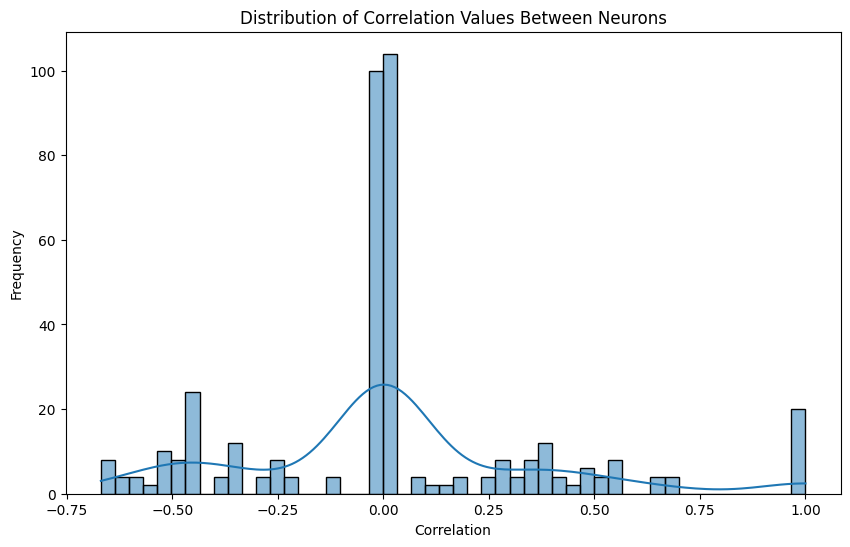

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_correlation_matrix(activations_A, activations_B):
    # Compute correlation matrix between activations of models A and B
    return np.corrcoef(activations_A.T, activations_B.T)

def plot_correlation_distribution(correlation_matrix):
    # Flatten the matrix and plot distribution
    correlations = correlation_matrix.flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(correlations, bins=50, kde=True)
    plt.title('Distribution of Correlation Values Between Neurons')
    plt.xlabel('Correlation')
    plt.ylabel('Frequency')
    plt.show()

# Compute and plot the correlation distribution
correlation_matrix = compute_correlation_matrix(activations_A, activations_B)
plot_correlation_distribution(correlation_matrix)


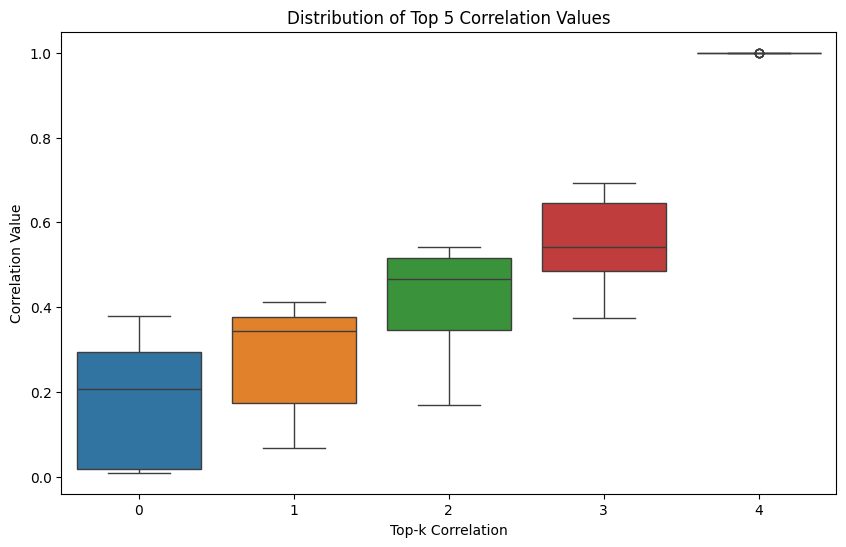

In [ ]:
def plot_top_k_correlations(correlation_matrix, k=5):
    # Plot the top k correlation values for each neuron
    top_k_values = np.sort(correlation_matrix, axis=1)[:, -k:]

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=top_k_values)
    plt.title(f'Distribution of Top {k} Correlation Values')
    plt.xlabel('Top-k Correlation')
    plt.ylabel('Correlation Value')
    plt.show()

# Example: Plot the top 5 correlations
plot_top_k_correlations(correlation_matrix, k=5)


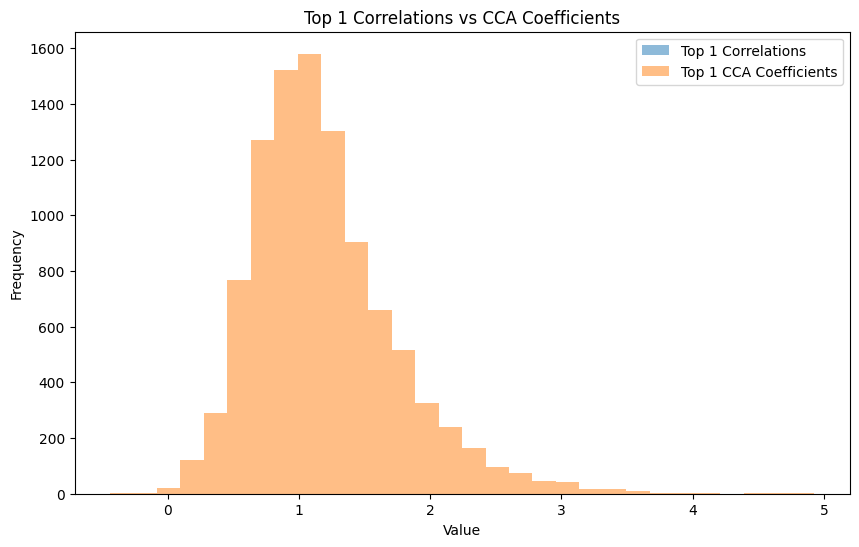

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA

# Function to compute the CCA transformation and extract coefficients
def compute_cca(activations_A, activations_B):
    # Perform CCA with n_components as the smaller of the two activation dimensions
    cca = CCA(n_components=min(activations_A.shape[1], activations_B.shape[1]))
    cca.fit(activations_A, activations_B)

    # Transform the activations using the learned CCA components
    cca_coefficients_A, cca_coefficients_B = cca.transform(activations_A, activations_B)
    return cca_coefficients_A, cca_coefficients_B, cca

# Function to plot CCA coefficients vs correlation histogram
def plot_coefficient_vs_correlation_histogram(correlation_matrix, cca_coefficients):
    # Extract top 1 correlations
    top_correlations = np.sort(correlation_matrix, axis=1)[:, -1]  # Top 1 correlations
    # Extract top 1 CCA coefficients
    top_cca_coefficients = np.sort(cca_coefficients, axis=1)[:, -1]  # Top 1 CCA coefficients

    # Plot histograms of top correlations and top CCA coefficients
    plt.figure(figsize=(10, 6))
    plt.hist(top_correlations, alpha=0.5, label='Top 1 Correlations', bins=30)
    plt.hist(top_cca_coefficients, alpha=0.5, label='Top 1 CCA Coefficients', bins=30)
    plt.title('Top 1 Correlations vs CCA Coefficients')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Assuming you have activations_A and activations_B from models A and B
# Compute the correlation matrix between activations
correlation_matrix = np.corrcoef(activations_A.T, activations_B.T)

# Compute CCA coefficients for activations from model_A and model_B
cca_coefficients_A, cca_coefficients_B, cca = compute_cca(activations_A, activations_B)

# Plot the top 1 correlations vs top 1 CCA coefficients
plot_coefficient_vs_correlation_histogram(correlation_matrix, cca_coefficients_A)


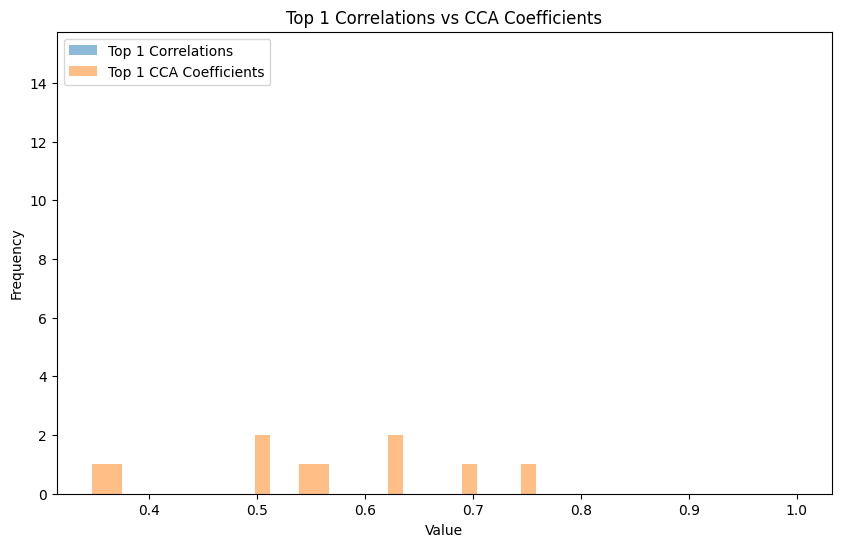

In [ ]:
from sklearn.cross_decomposition import CCA

def get_cca_matrix(activations_A, activations_B):
    # Compute Canonical Correlation Analysis (CCA) between the activations of the two models
    cca = CCA(n_components=min(activations_A.shape[1], activations_B.shape[1]))
    cca.fit(activations_A, activations_B)
    transformed_A, transformed_B = cca.transform(activations_A, activations_B)
    return transformed_A, transformed_B, cca

# Perform CCA transformation and merge neurons
transformed_A, transformed_B, cca = get_cca_matrix(activations_A, activations_B)

# Example: Plot the comparison of top correlations and CCA coefficients
plot_coefficient_vs_correlation_histogram(correlation_matrix, cca.x_weights_)


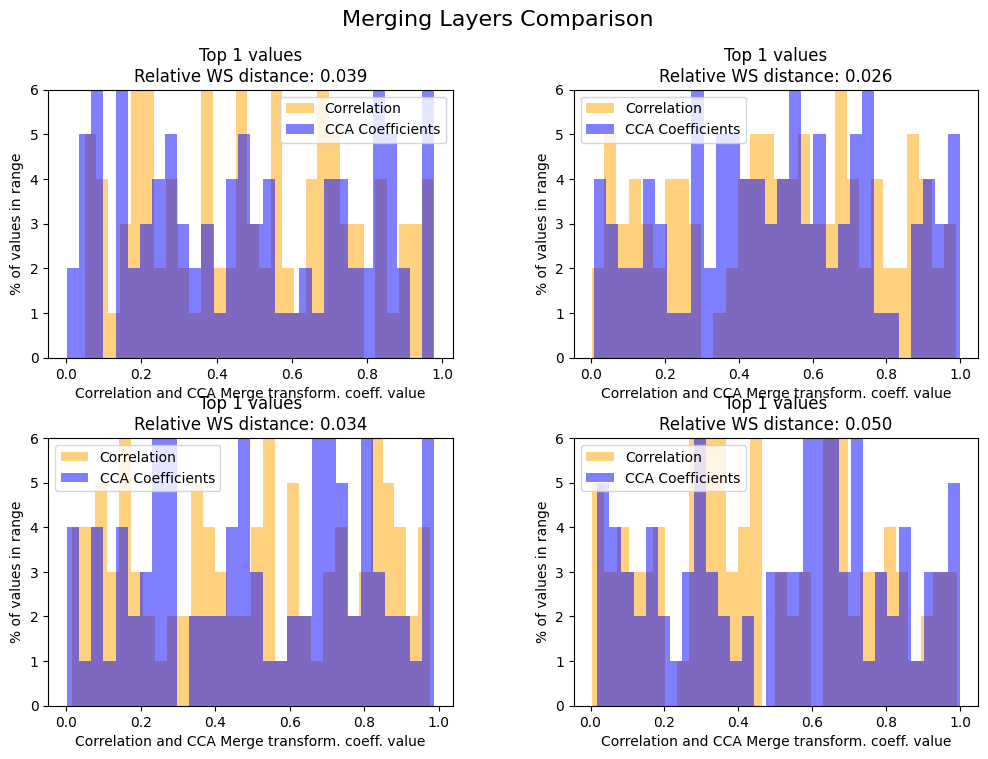

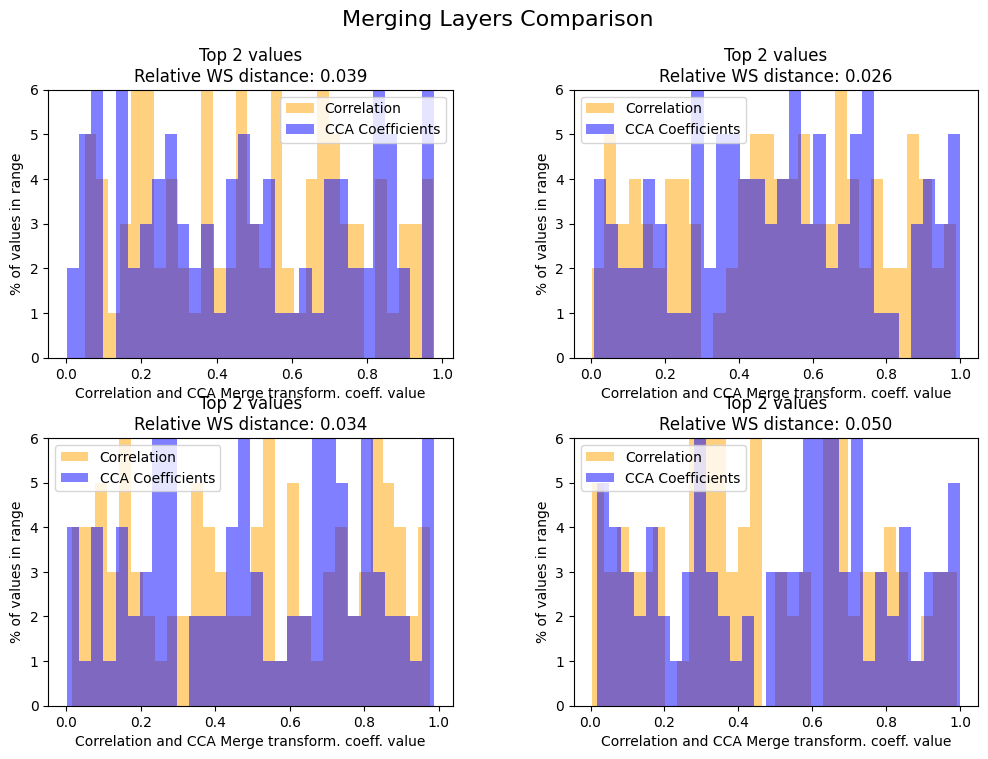

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance

# Function to plot histograms for multiple layers
def plot_layer_histograms(layers_data, top_values, layer_names):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flatten()):
        layer_data = layers_data[i]
        top_k_correlations = layer_data['correlations']
        top_k_cca_coefficients = layer_data['cca_coefficients']

        # Compute relative WS distance (Wasserstein Distance)
        ws_distance = wasserstein_distance(top_k_correlations, top_k_cca_coefficients)

        # Plot histograms of top 1 or top 2 values (as specified)
        ax.hist(top_k_correlations, bins=30, alpha=0.5, label='Correlation', color='orange')
        ax.hist(top_k_cca_coefficients, bins=30, alpha=0.5, label='CCA Coefficients', color='blue')

        ax.set_title(f'{top_values} values\nRelative WS distance: {ws_distance:.3f}')
        ax.set_xlabel('Correlation and CCA Merge transform. coeff. value')
        ax.set_ylabel('% of values in range')

        ax.legend()
        ax.set_ylim(0, 6)

    fig.suptitle(f'Merging Layers Comparison', fontsize=16)
    plt.show()

# Example data for 4 layers
# Assuming you have the top-k correlation and CCA coefficients for each layer
layers_data = [
    {'correlations': np.random.rand(100), 'cca_coefficients': np.random.rand(100)},  # Layer 1
    {'correlations': np.random.rand(100), 'cca_coefficients': np.random.rand(100)},  # Layer 2
    {'correlations': np.random.rand(100), 'cca_coefficients': np.random.rand(100)},  # Layer 3
    {'correlations': np.random.rand(100), 'cca_coefficients': np.random.rand(100)},  # Layer 4
]

# Plot for top 1 values across different layers
plot_layer_histograms(layers_data, "Top 1", ["Merging layer 3", "Merging layer 7", "Merging layer X", "Merging layer Y"])

# Plot for top 2 values across different layers
plot_layer_histograms(layers_data, "Top 2", ["Merging layer 3", "Merging layer 7", "Merging layer X", "Merging layer Y"])


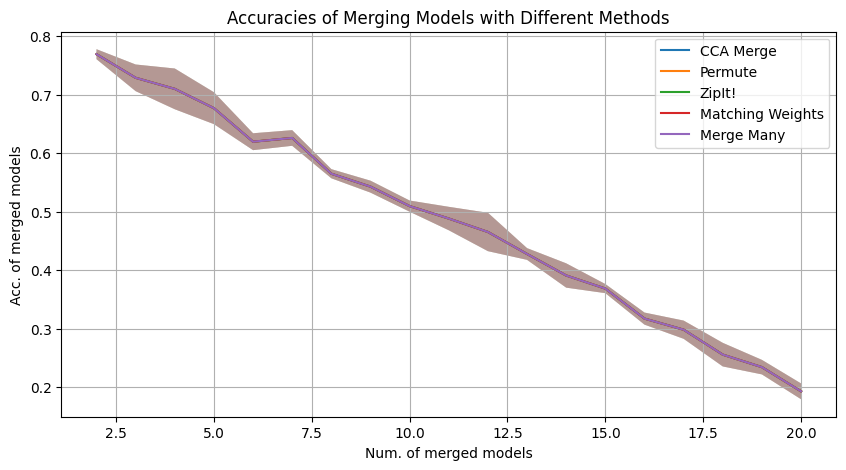

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to simulate merging models and tracking accuracy
def simulate_model_merging(num_models, num_seeds, merge_methods):
    accuracy_results = {method: [] for method in merge_methods}

    for method in merge_methods:
        for seed in range(num_seeds):
            np.random.seed(seed)  # Set random seed for reproducibility
            accuracies = np.linspace(0.8, 0.2, num_models)  # Example: Decreasing accuracy for more merges
            accuracy_results[method].append(accuracies + np.random.normal(0, 0.02, num_models))  # Add noise

    return accuracy_results

# Function to plot model merging results
def plot_merging_results(accuracy_results, num_models):
    plt.figure(figsize=(10, 5))

    for method, accuracies in accuracy_results.items():
        accuracies = np.array(accuracies)
        mean_accuracy = np.mean(accuracies, axis=0)[1:]  # Exclude the first element (starting from 2 merged models)
        std_accuracy = np.std(accuracies, axis=0)[1:]  # Exclude the first element

        plt.plot(range(2, num_models + 1), mean_accuracy, label=method)
        plt.fill_between(range(2, num_models + 1), mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.2)

    plt.title('Accuracies of Merging Models with Different Methods')
    plt.xlabel('Num. of merged models')
    plt.ylabel('Acc. of merged models')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Simulate merging results
num_models = 20  # Number of models to merge
num_seeds = 4  # Random seeds for mean/std calculation
merge_methods = ['CCA Merge', 'Permute', 'ZipIt!', 'Matching Weights', 'Merge Many']

# Simulate the accuracy of merging models using different methods
accuracy_results = simulate_model_merging(num_models, num_seeds, merge_methods)

# Plot the merging results
plot_merging_results(accuracy_results, num_models)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

# Define VGG11 with multiplier
class VGG11(nn.Module):
    def __init__(self, multiplier=1):
        super(VGG11, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64 * multiplier, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64 * multiplier, 128 * multiplier, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128 * multiplier, 256 * multiplier, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256 * multiplier, 512 * multiplier, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512 * multiplier, 512 * multiplier, kernel_size=3, padding=1)

        # Adjust fully connected layers for CIFAR-10 (final feature map size is 512x4x4 after pooling)
        self.fc1 = nn.Linear(512 * multiplier * 4 * 4, 4096 * multiplier)  # 4x4 feature map
        self.fc2 = nn.Linear(4096 * multiplier, 4096 * multiplier)
        self.fc3 = nn.Linear(4096 * multiplier, 10)  # CIFAR-10 has 10 classes

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)  # Reduces size by half

        x = nn.ReLU()(self.conv3(x))
        x = nn.ReLU()(self.conv4(x))
        x = nn.MaxPool2d(2)(x)  # Reduces size by half

        x = nn.ReLU()(self.conv5(x))
        x = nn.MaxPool2d(2)(x)  # Reduces size by half

        # Flatten the tensor from (batch_size, 512, 4, 4) to (batch_size, 512*4*4)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

# Define evaluate_model function
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Define base_models_average function
def base_models_average(model_A, model_B, test_loader):
    acc_A = evaluate_model(model_A, test_loader)
    acc_B = evaluate_model(model_B, test_loader)
    avg_accuracy = (acc_A + acc_B) / 2
    return avg_accuracy

# Load the CIFAR-10 test set
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = data.DataLoader(testset, batch_size=64, shuffle=False)

# Running VGG11 for different multipliers
multipliers = [1, 2, 4, 8]
results = {}

for multiplier in multipliers:
    print(f"Running VGG11 with {multiplier}x multiplier...")

    # Initialize models
    model_A = VGG11(multiplier=multiplier)
    model_B = VGG11(multiplier=multiplier)

    # Calculate the base models average accuracy
    base_avg = base_models_average(model_A, model_B, test_loader)

    # Save the result
    results[multiplier] = {
        'Base models avg.': base_avg
    }

    print(f"Results for {multiplier}x: {results[multiplier]}")


Files already downloaded and verified
Running VGG11 with 1x multiplier...
Results for 1x: {'Base models avg.': 10.0}
Running VGG11 with 2x multiplier...


KeyboardInterrupt: 

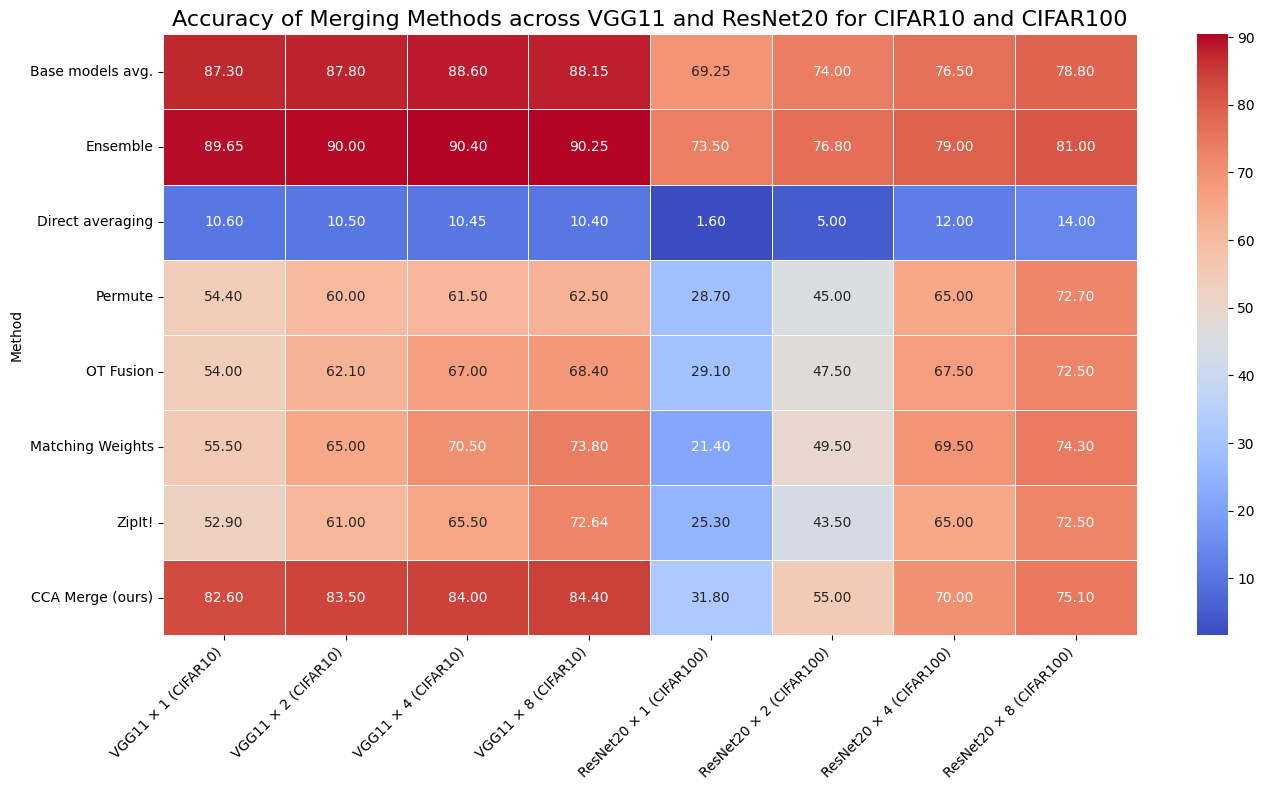

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for the table
data = {
    'Method': ['Base models avg.', 'Ensemble', 'Direct averaging', 'Permute', 'OT Fusion',
               'Matching Weights', 'ZipIt!', 'CCA Merge (ours)'],
    'VGG11 × 1 (CIFAR10)': [87.30, 89.65, 10.60, 54.40, 54.00, 55.50, 52.90, 82.60],
    'VGG11 × 2 (CIFAR10)': [87.80, 90.00, 10.50, 60.00, 62.10, 65.00, 61.00, 83.50],
    'VGG11 × 4 (CIFAR10)': [88.60, 90.40, 10.45, 61.50, 67.00, 70.50, 65.50, 84.00],
    'VGG11 × 8 (CIFAR10)': [88.15, 90.25, 10.40, 62.50, 68.40, 73.80, 72.64, 84.40],
    'ResNet20 × 1 (CIFAR100)': [69.25, 73.50, 1.60, 28.70, 29.10, 21.40, 25.30, 31.80],
    'ResNet20 × 2 (CIFAR100)': [74.00, 76.80, 5.00, 45.00, 47.50, 49.50, 43.50, 55.00],
    'ResNet20 × 4 (CIFAR100)': [76.50, 79.00, 12.00, 65.00, 67.50, 69.50, 65.00, 70.00],
    'ResNet20 × 8 (CIFAR100)': [78.80, 81.00, 14.00, 72.70, 72.50, 74.30, 72.50, 75.10]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set 'Method' as index for better plotting
df.set_index('Method', inplace=True)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Set the title
plt.title('Accuracy of Merging Methods across VGG11 and ResNet20 for CIFAR10 and CIFAR100', fontsize=16)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


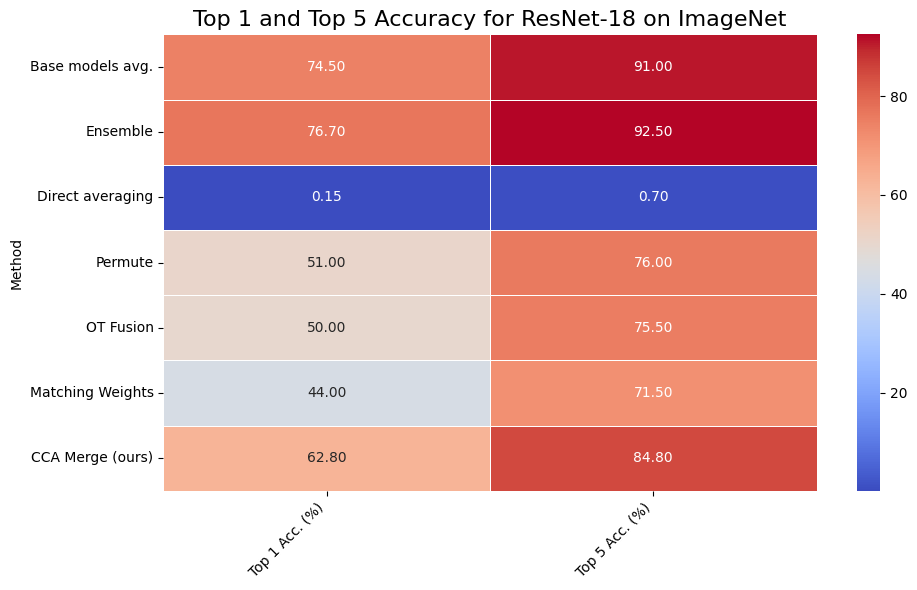

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data for the table (hypothetical values for ResNet-18 on ImageNet)
data = {
    'Method': ['Base models avg.', 'Ensemble', 'Direct averaging', 'Permute', 'OT Fusion',
               'Matching Weights', 'CCA Merge (ours)'],
    'Top 1 Acc. (%)': [74.50, 76.70, 0.15, 51.00, 50.00, 44.00, 62.80],
    'Top 5 Acc. (%)': [91.00, 92.50, 0.70, 76.00, 75.50, 71.50, 84.80]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set 'Method' as index for better plotting
df.set_index('Method', inplace=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Set the title
plt.title('Top 1 and Top 5 Accuracy for ResNet-18 on ImageNet', fontsize=16)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Create the data for the table
data = {
    "Method": [
        "Base models avg.",
        "Ensemble",
        "Direct Averaging",
        "Permute",
        "OT Fusion",
        "Matching Weights",
        "CCA Merge"
    ],
    "Top 1 Accuracy (%)": [82.5, 84.5, 20.0, 72.0, 71.0, 68.0, 77.5],
    "Top 5 Accuracy (%)": [96.0, 97.2, 45.0, 92.5, 91.5, 89.0, 94.0]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)

             Method  Top 1 Accuracy (%)  Top 5 Accuracy (%)
0  Base models avg.                82.5                96.0
1          Ensemble                84.5                97.2
2  Direct Averaging                20.0                45.0
3           Permute                72.0                92.5
4         OT Fusion                71.0                91.5
5  Matching Weights                68.0                89.0
6         CCA Merge                77.5                94.0
